### Assignment 1 (4 scores):

- Use Numpy only to construct the Logistic Regression model.
- Train that Logistic Regression model dataset using the Gradient Descend approach on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset. *Note that three class in this dataset must be merge into two class as: graduate and non-graduate (dropout or enroll)*.
- Evaluate that Logistic Regression model on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Visualize the loss function of the training process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [3]:
DATA_PATH = "data.csv"
df = pd.read_csv(DATA_PATH, delimiter=';', encoding='utf-8', low_memory=False)

print("Kích thước dữ liệu:", df.shape)
print("Tên cột:", df.columns.tolist())
df.head()

Kích thước dữ liệu: (4424, 37)
Tên cột: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Infla

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
print("Giá trị nhãn duy nhất:", df["Target"].unique())

# Graduate -> 1, Dropout hoặc Enrolled -> 0
def map_label(x):
    s = str(x).lower()
    if 'gradu' in s:
        return 1
    return 0

y = df["Target"].apply(map_label).values

Giá trị nhãn duy nhất: ['Dropout' 'Graduate' 'Enrolled']


In [ ]:
X_df = df.drop(columns=["Target"])

num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_df.columns if c not in num_cols]

if len(cat_cols) > 0:
    X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)

X = X_df.select_dtypes(include=[np.number]).values
print("Kích thước X ban đầu:", X.shape)

if np.isnan(X).any():
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])

mu = X.mean(axis=0)
sigma = X.std(axis=0)
sigma[sigma == 0] = 1
X = (X - mu) / sigma

X = np.hstack([np.ones((X.shape[0], 1)), X])

print("Kích thước X sau chuẩn hóa:", X.shape)


Kích thước X ban đầu: (4424, 36)
Kích thước X sau chuẩn hóa: (4424, 37)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Tỷ lệ graduate (train):", y_train.mean())


Train shape: (3539, 37)
Test shape: (885, 37)
Tỷ lệ graduate (train): 0.4992935857586889


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss_and_grad(w, Xb, yb, l2=0.0):
    m = Xb.shape[0]
    z = Xb.dot(w)
    p = sigmoid(z)
    eps = 1e-12
    loss = - (yb * np.log(p + eps) + (1 - yb) * np.log(1 - p + eps)).mean()
    if l2 > 0:
        loss += 0.5 * l2 * np.sum(w[1:]**2) / m
    grad = (Xb.T.dot(p - yb)) / m
    if l2 > 0:
        reg = np.concatenate([[0.0], l2 * w[1:] / m])
        grad += reg
    return loss, grad

LR = 0.1
EPOCHS = 1000
BATCH_SIZE = 64
L2 = 0.0

w = np.zeros(X_train.shape[1])
loss_history = []

for epoch in range(EPOCHS):
    perm = np.random.permutation(len(X_train))
    Xs = X_train[perm]
    ys = y_train[perm]
    epoch_loss = 0
    batches = int(np.ceil(len(Xs) / BATCH_SIZE))
    for i in range(batches):
        start, end = i * BATCH_SIZE, min((i+1) * BATCH_SIZE, len(Xs))
        Xb, yb = Xs[start:end], ys[start:end]
        loss, grad = compute_loss_and_grad(w, Xb, yb, L2)
        w -= LR * grad
        epoch_loss += loss * (end - start)
    epoch_loss /= len(Xs)
    loss_history.append(epoch_loss)
    if (epoch + 1) % (EPOCHS // 10 if EPOCHS >= 10 else 1) == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f}")


Epoch 100/1000 - Loss: 0.325065
Epoch 200/1000 - Loss: 0.324721
Epoch 300/1000 - Loss: 0.324856
Epoch 400/1000 - Loss: 0.324973
Epoch 500/1000 - Loss: 0.325055
Epoch 600/1000 - Loss: 0.324791
Epoch 700/1000 - Loss: 0.325087
Epoch 800/1000 - Loss: 0.325184
Epoch 900/1000 - Loss: 0.324868
Epoch 1000/1000 - Loss: 0.324856


Accuracy: 0.8248587570621468
Confusion Matrix:
 [[342 101]
 [ 54 388]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8636    0.7720    0.8153       443
           1     0.7935    0.8778    0.8335       442

    accuracy                         0.8249       885
   macro avg     0.8285    0.8249    0.8244       885
weighted avg     0.8286    0.8249    0.8244       885

ROC AUC: 0.9006618796155378


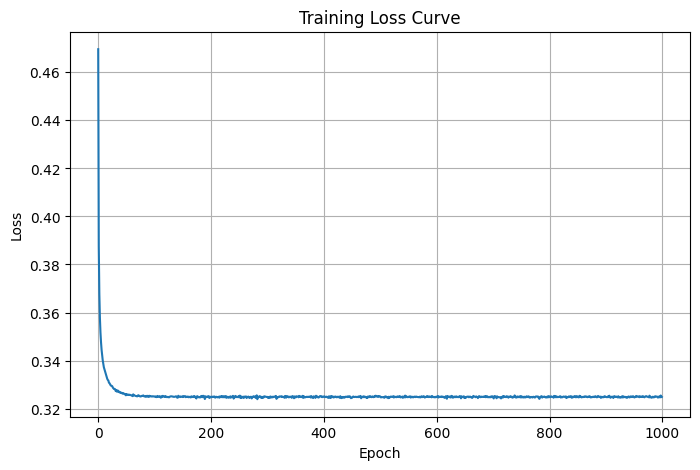

In [8]:
def predict_proba(Xb, w):
    return sigmoid(Xb.dot(w))

def predict(Xb, w, threshold=0.5):
    return (predict_proba(Xb, w) >= threshold).astype(int)

# Dự đoán
y_pred = predict(X_test, w)
y_prob = predict_proba(X_test, w)

# Đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except:
    pass

# Vẽ Loss
plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Assignment 2 (4 scores):

- Use Numpy only to construct the Sofmax Regression model.
- Train that Logistic Regression model dataset using the Gradient Descend approach on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Evaluate that Logistic Regression model on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Visualize the loss function of the training process.

### Assignment 3 (2 scores):

- Use a Machine Learning library (Scikit Learn or Skorch) to implement and evaluate the Logistic Regression on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Use a Machine Learning library (Scikit Learn or Skorch) to implement and evaluate the Softmax Regression on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.